Epoch 1, Loss: 0.1111, PSNR: 10.25, SSIM: 0.1841
Epoch 2, Loss: 0.0520, PSNR: 13.28, SSIM: 0.3121
Epoch 3, Loss: 0.0467, PSNR: 13.75, SSIM: 0.3164
Epoch 4, Loss: 0.0449, PSNR: 13.88, SSIM: 0.3232
Epoch 5, Loss: 0.0442, PSNR: 14.04, SSIM: 0.3246
Epoch 6, Loss: 0.0427, PSNR: 14.16, SSIM: 0.3322
Epoch 7, Loss: 0.0426, PSNR: 14.14, SSIM: 0.3418
Epoch 8, Loss: 0.0409, PSNR: 14.37, SSIM: 0.3487
Epoch 9, Loss: 0.0412, PSNR: 14.34, SSIM: 0.3611
Epoch 10, Loss: 0.0397, PSNR: 14.62, SSIM: 0.3655
Epoch 11, Loss: 0.0395, PSNR: 14.49, SSIM: 0.3766
Epoch 12, Loss: 0.0407, PSNR: 14.46, SSIM: 0.3717
Epoch 13, Loss: 0.0385, PSNR: 14.63, SSIM: 0.3816
Epoch 14, Loss: 0.0387, PSNR: 14.58, SSIM: 0.3857
Epoch 15, Loss: 0.0376, PSNR: 14.75, SSIM: 0.3881
Epoch 16, Loss: 0.0378, PSNR: 14.72, SSIM: 0.3925
Epoch 17, Loss: 0.0374, PSNR: 14.78, SSIM: 0.3925
Epoch 18, Loss: 0.0369, PSNR: 14.83, SSIM: 0.3967
Epoch 19, Loss: 0.0372, PSNR: 14.79, SSIM: 0.4019
Epoch 20, Loss: 0.0370, PSNR: 14.84, SSIM: 0.3997
Epoch 21,

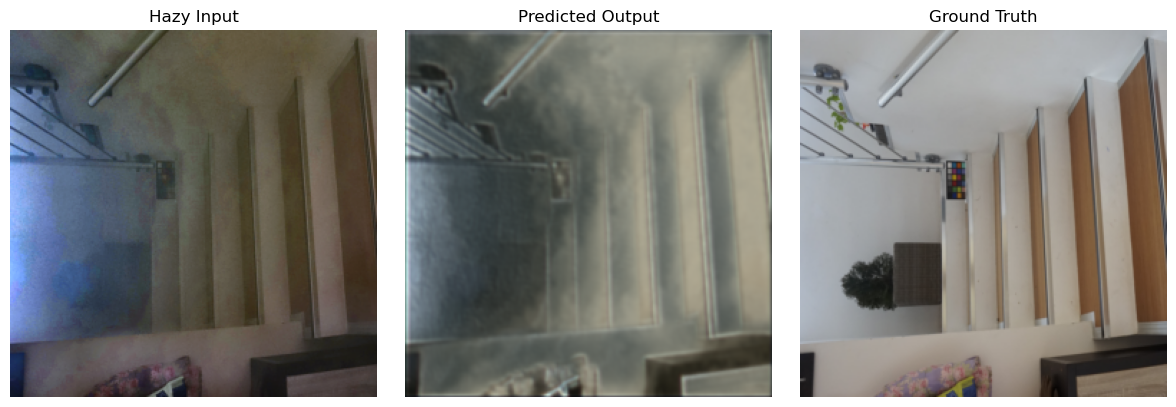

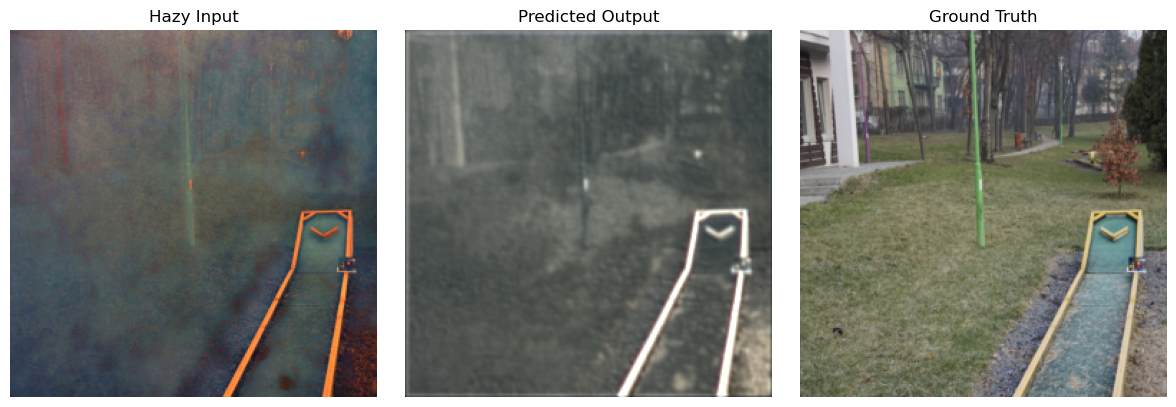

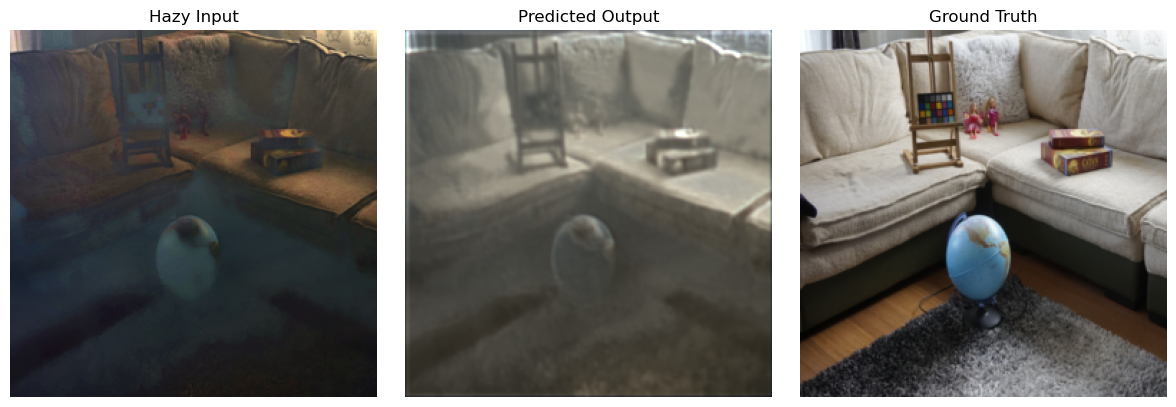

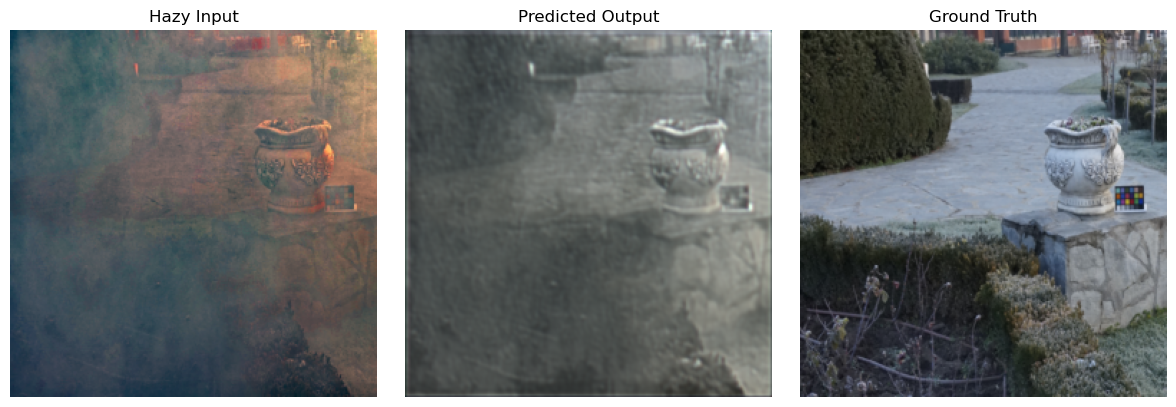

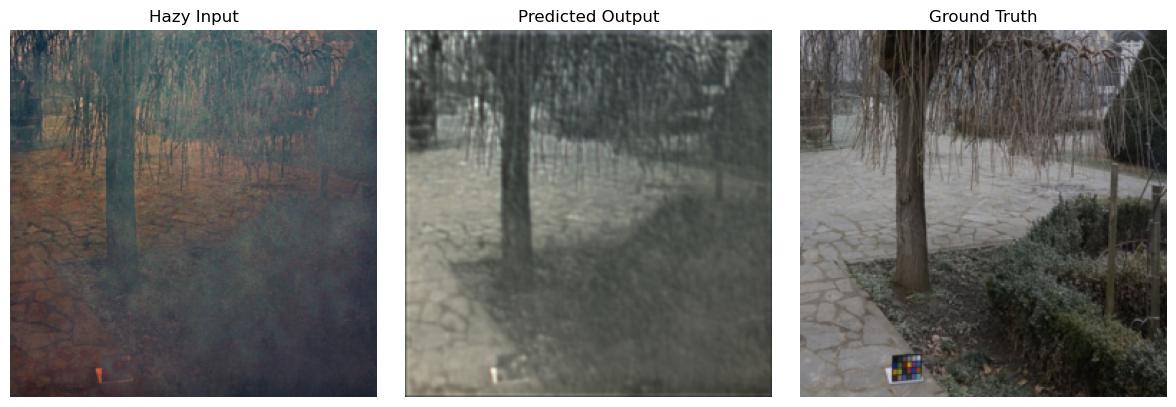

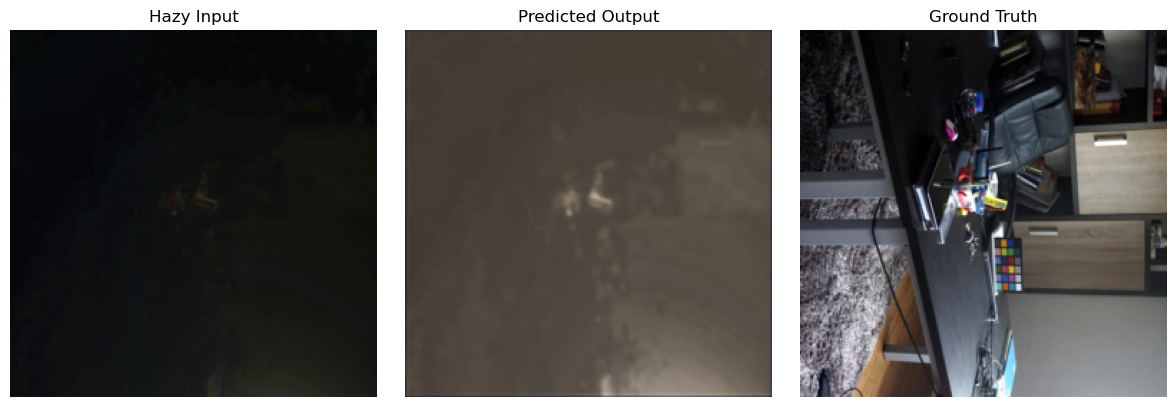

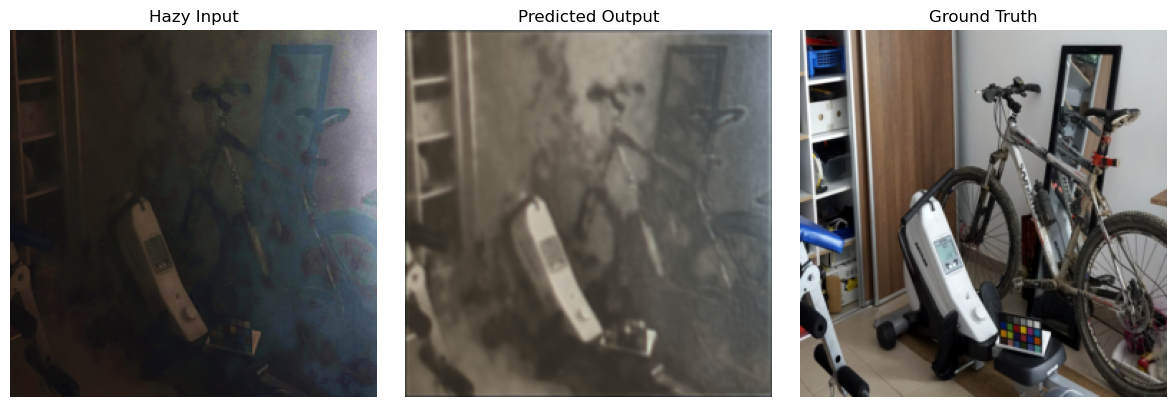

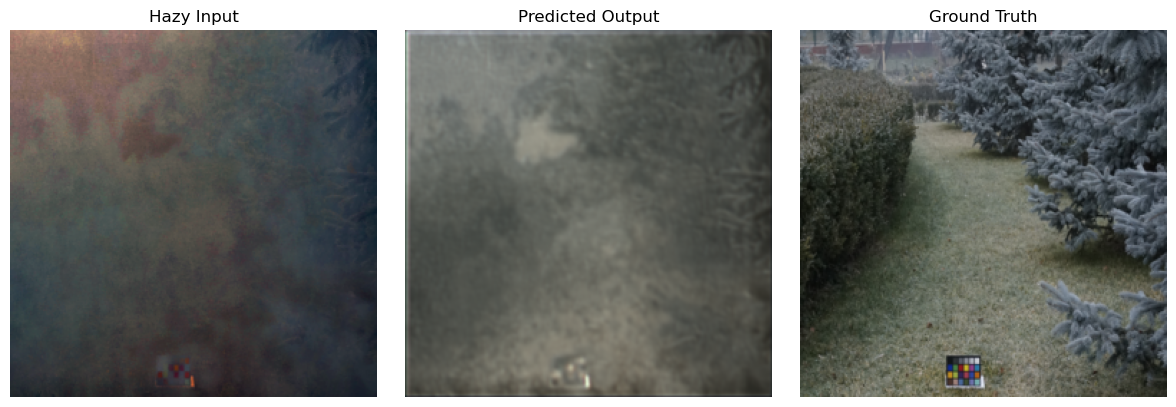

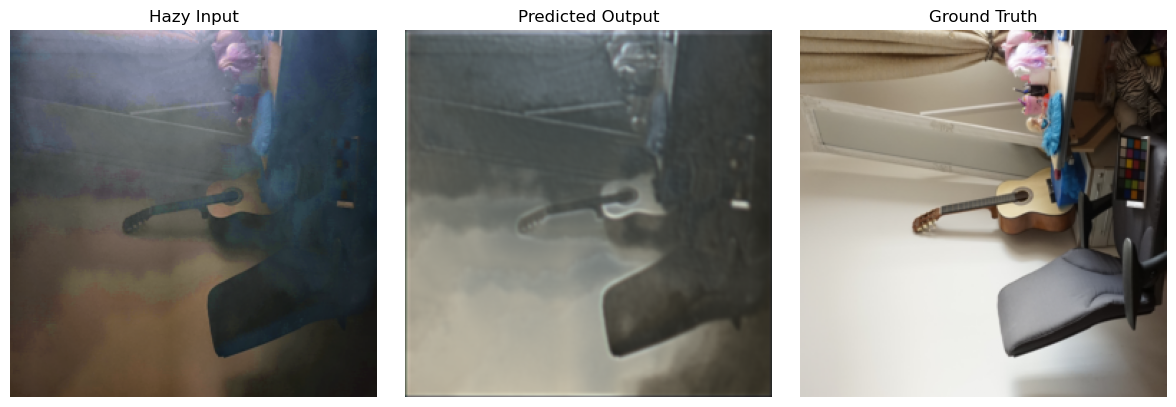

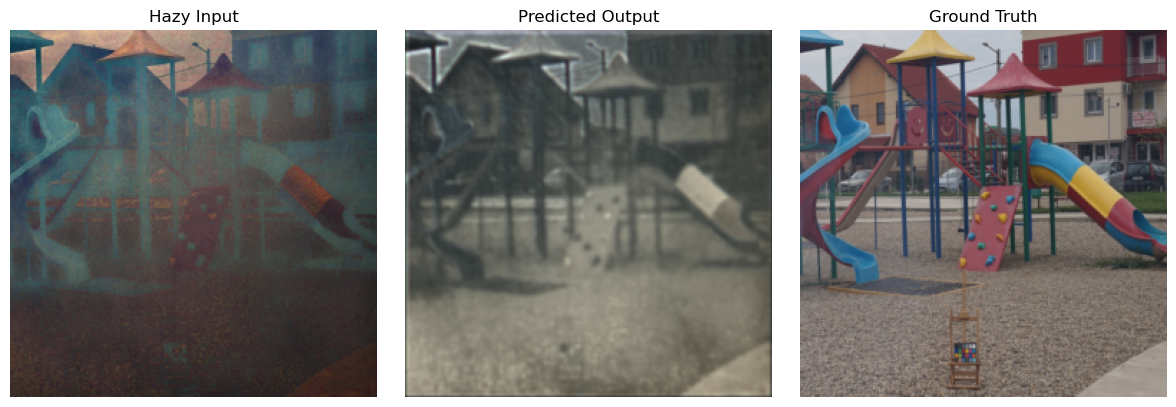


Test Set - Average PSNR: 16.28, Average SSIM: 0.4964


In [2]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# PSNR and SSIM functions
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 10 * torch.log10(1.0 / mse).item()

def calculate_ssim(img1, img2, window_size=11, C1=0.01**2, C2=0.03**2):
    mu1 = F.avg_pool2d(img1, kernel_size=window_size, stride=1, padding=window_size // 2)
    mu2 = F.avg_pool2d(img2, kernel_size=window_size, stride=1, padding=window_size // 2)
    sigma1_sq = F.avg_pool2d(img1 * img1, kernel_size=window_size, stride=1, padding=window_size // 2) - mu1 ** 2
    sigma2_sq = F.avg_pool2d(img2 * img2, kernel_size=window_size, stride=1, padding=window_size // 2) - mu2 ** 2
    sigma12 = F.avg_pool2d(img1 * img2, kernel_size=window_size, stride=1, padding=window_size // 2) - mu1 * mu2
    ssim_map = ((2 * mu1 * mu2 + C1) * (2 * sigma12 + C2)) / ((mu1 ** 2 + mu2 ** 2 + C1) * (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean().item()

# Model Components
class SimpleViT(nn.Module):
    def __init__(self, in_channels=3, embed_dim=256):
        super(SimpleViT, self).__init__()
        self.conv = nn.Conv2d(in_channels, embed_dim, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.mean(dim=[2, 3])  # Global average pooling
        x = self.fc(x)
        return x

class SimpleMamba(nn.Module):
    def __init__(self, embed_dim=256):
        super(SimpleMamba, self).__init__()
        self.rnn = nn.GRU(embed_dim, embed_dim, batch_first=True)

    def forward(self, x):
        x = x.unsqueeze(1)  # Sequence length = 1
        out, _ = self.rnn(x)
        return out.squeeze(1)

class DehazingModel(nn.Module):
    def __init__(self):
        super(DehazingModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU()
        )
        self.vit = SimpleViT(128, 256)
        self.mamba = SimpleMamba(256)
        self.project_back = nn.Linear(256, 128)
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1)
        )

    def forward(self, x):
        enc = self.encoder(x)
        vit_feat = self.vit(enc)
        mamba_feat = self.mamba(vit_feat)
        mamba_feat = self.project_back(mamba_feat)
        mamba_feat = mamba_feat.unsqueeze(-1).unsqueeze(-1)
        fusion = enc + mamba_feat
        out = self.decoder(fusion)
        return out

# Dataset
class SOTSDehazingDataset(Dataset):
    def __init__(self, hazy_list, clear_list, transform=None):
        self.hazy_images = hazy_list
        self.clear_images = clear_list
        self.transform = transform

    def __len__(self):
        return len(self.hazy_images)

    def __getitem__(self, idx):
        hazy = Image.open(self.hazy_images[idx]).convert("RGB")
        clear = Image.open(self.clear_images[idx]).convert("RGB")
        if self.transform:
            hazy = self.transform(hazy)
            clear = self.transform(clear)
        return hazy, clear

# Paths
hazy_path = "hazy_processed"
clear_path = "GT"

# File lists
hazy_images = sorted(glob.glob(os.path.join(hazy_path, '*')))
clear_images = sorted(glob.glob(os.path.join(clear_path, '*')))

# Split into train/test
train_hazy, test_hazy, train_clear, test_clear = train_test_split(
    hazy_images, clear_images, test_size=0.2, random_state=42
)

# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Datasets and loaders
train_dataset = SOTSDehazingDataset(train_hazy, train_clear, transform)
test_dataset = SOTSDehazingDataset(test_hazy, test_clear, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model, loss, optimizer
model = DehazingModel().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# Training loop
for epoch in range(70):
    model.train()
    total_loss = 0
    total_psnr = 0
    total_ssim = 0
    for hazy, clear in train_loader:
        hazy, clear = hazy.cuda(), clear.cuda()
        output = model(hazy)
        loss = criterion(output, clear)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        for i in range(hazy.size(0)):
            psnr = calculate_psnr(output[i:i+1], clear[i:i+1])
            ssim = calculate_ssim(output[i:i+1], clear[i:i+1])
            total_psnr += psnr
            total_ssim += ssim
    avg_loss = total_loss / len(train_loader)
    avg_psnr = total_psnr / len(train_dataset)
    avg_ssim = total_ssim / len(train_dataset)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

# Save model
torch.save(model.state_dict(), "mamba_vit_100dddehazing.pth")

# Evaluation on test set
model.eval()
psnr_total, ssim_total = 0, 0
predictions_shown = 0

with torch.no_grad():
    for i, (hazy, clear) in enumerate(test_loader):
        hazy, clear = hazy.cuda(), clear.cuda()
        output = model(hazy)

        psnr = calculate_psnr(output, clear)
        ssim = calculate_ssim(output, clear)
        psnr_total += psnr
        ssim_total += ssim

        # Show first 10 predictions
        if predictions_shown < 10:
            pred_img = output[0].cpu().clamp(0, 1)
            clear_img = clear[0].cpu().clamp(0, 1)
            hazy_img = hazy[0].cpu().clamp(0, 1)

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(np.transpose(hazy_img.numpy(), (1, 2, 0)))
            axs[0].set_title("Hazy Input")
            axs[1].imshow(np.transpose(pred_img.numpy(), (1, 2, 0)))
            axs[1].set_title("Predicted Output")
            axs[2].imshow(np.transpose(clear_img.numpy(), (1, 2, 0)))
            axs[2].set_title("Ground Truth")
            for ax in axs:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

            predictions_shown += 1

# Final average scores
avg_psnr = psnr_total / len(test_dataset)
avg_ssim = ssim_total / len(test_dataset)
print(f"\nTest Set - Average PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.4f}")


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from einops import rearrange
import os

try:
    from mamba_ssm import Mamba
    MAMBA_AVAILABLE = True
except ImportError:
    MAMBA_AVAILABLE = False
    print("mamba_ssm not found. Using convolutional fallback for MambaBlock.")

# DNA Encoder (Aligned with Pradhan et al., 2024)
class DNAEncoder(nn.Module):
    def __init__(self):
        super(DNAEncoder, self).__init__()
        self.conv = nn.Conv2d(12, 64, kernel_size=3, padding=1)  # 12 DNA planes (4 per RGB)

    def encode_dna(self, image):
        # Input: (B, 3, H, W), normalized [0, 1]
        # Scale to 0-255
        image = (image * 255).to(torch.uint8)
        B, C, H, W = image.shape
        # Convert to 8-bit binary
        bits = torch.zeros(B, C, H, W, 8, device=image.device)
        for i in range(8):
            bits[..., i] = (image >> (7 - i)) & 1
        # Group into 4 bit pairs (8,7; 6,5; 4,3; 2,1)
        bit_pairs = torch.stack([
            bits[..., 0:2],  # MSB 8,7
            bits[..., 2:4],  # 6,5
            bits[..., 4:6],  # 4,3
            bits[..., 6:8]   # LSB 2,1
        ], dim=-2)  # (B, C, H, W, 4, 2)
        # Map bit pairs to nucleotides (00=A, 01=T, 10=C, 11=G)
        pair_values = bit_pairs[..., 0] * 2 + bit_pairs[..., 1]  # 0=A, 1=T, 2=C, 3=G
        dna_planes = pair_values  # (B, C, H, W, 4)
        # Reshape to (B, C*4, H, W) = (B, 12, H, W)
        dna_planes = dna_planes.permute(0, 1, 4, 2, 3).reshape(B, C * 4, H, W)
        # Rule-1: Numeric translation (A=0, T=1, C=2, G=3)
        numeric_planes = dna_planes.float()
        # Amplification (weighted by plane significance, approximating Eq. 2, 3)
        weights = torch.tensor([4.0, 3.0, 2.0, 1.0], device=image.device).view(1, 4, 1, 1)
        weights = weights.repeat(1, 3, 1, 1).view(1, 12, 1, 1)
        amplified = numeric_planes * weights
        return amplified

    def forward(self, x):
        dna_planes = self.encode_dna(x)
        features = self.conv(dna_planes)
        return features  # (B, 64, H, W)

# Transformer Block (Lightweight ViT)
class TransformerBlock(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=128, num_heads=4, num_layers=2):
        super(TransformerBlock, self).__init__()
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Linear(patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        # Patchify
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        # Embed
        x = self.patch_embed(x) + self.pos_embed
        # Transformer
        x = self.transformer(x)
        x = self.fc(x)
        # Reshape back
        x = rearrange(x, 'b (h w) -> b c h w', h=H//self.patch_size, w=W//self.patch_size)
        return x

# Mamba Block (Using mamba_ssm or fallback)
class MambaBlock(nn.Module):
    def __init__(self, d_model=64, d_state=16, d_conv=4, expand=2):
        super(MambaBlock, self).__init__()
        if MAMBA_AVAILABLE:
            self.mamba = Mamba(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand
            )
        else:
            self.mamba = nn.Sequential(
                nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
                nn.LayerNorm([d_model, 256, 256]),
                nn.ReLU()
            )
        self.fc = nn.Linear(d_model, d_model) if MAMBA_AVAILABLE else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if MAMBA_AVAILABLE:
            # Reshape to sequence
            x = rearrange(x, 'b c h w -> b (h w) c')
            out = self.mamba(x)
            out = self.fc(out)
            out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        else:
            out = self.mamba(x)
        return out

# Cross-Attention Fusion Module
class CrossAttentionFusion(nn.Module):
    def __init__(self, dna_dim=64, trans_dim=128, mamba_dim=64, embed_dim=64):
        super(CrossAttentionFusion, self).__init__()
        self.query_conv = nn.Conv2d(dna_dim, embed_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.scale = embed_dim ** -0.5
        self.out_conv = nn.Conv2d(embed_dim + dna_dim, embed_dim, kernel_size=1)
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(embed_dim, embed_dim//16, 1),
            nn.ReLU(),
            nn.Conv2d(embed_dim//16, embed_dim, 1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(embed_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, dna_features, trans_features, mamba_features):
        B, _, H, W = dna_features.shape
        Q = self.query_conv(dna_features)
        combined = torch.cat([trans_features, mamba_features], dim=1)
        K = self.key_conv(combined)
        V = self.value_conv(combined)
        # Cross-attention
        Q = rearrange(Q, 'b c h w -> b (h w) c')
        K = rearrange(K, 'b c h w -> b (h w) c')
        V = rearrange(V, 'b c h w -> b (h w) c')
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        # Residual with DNA
        out = torch.cat([out, dna_features], dim=1)
        out = self.out_conv(out)
        # Channel and spatial attention
        out = out * self.channel_attn(out)
        out = out * self.spatial_attn(out)
        return out

# Hybrid Dehazing Model
class HybridDehazingModel(nn.Module):
    def __init__(self, img_size=256):
        super(HybridDehazingModel, self).__init__()
        self.dna_encoder = DNAEncoder()
        self.transformer = TransformerBlock(img_size=img_size)
        self.mamba = MambaBlock()
        self.fusion = CrossAttentionFusion()
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        dna_features = self.dna_encoder(x)
        trans_features = self.transformer(x)
        trans_features = F.interpolate(trans_features, size=x.shape[2:], mode='bilinear', align_corners=False)
        mamba_features = self.mamba(dna_features)
        fused = self.fusion(dna_features, trans_features, mamba_features)
        out = self.decoder(fused)
        return out

# Real Dataset
class RealHazyDataset(torch.utils.data.Dataset):
    def __init__(self, hazy_dir, clear_dir, img_size=256):
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.hazy_files = sorted([f for f in os.listdir(hazy_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.clear_files = sorted([f for f in os.listdir(clear_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        assert len(self.hazy_files) == len(self.clear_files), "Hazy and clear directories must have the same number of images"
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.hazy_files[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_files[idx])
        hazy = Image.open(hazy_path).convert('RGB')
        clear = Image.open(clear_path).convert('RGB')
        return self.transform(hazy), self.transform(clear)

# Training and Evaluation
def train_model(model, dataset, num_epochs=10, batch_size=8, device='cuda'):
    model.train()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    psnr_history = []
    ssim_history = []

    for epoch in range(num_epochs):
        epoch_psnr = 0.0
        epoch_ssim = 0.0
        num_batches = 0

        for hazy, clear in loader:
            hazy, clear = hazy.to(device), clear.to(device)
            optimizer.zero_grad()
            dehazed = model(hazy)
            loss = criterion(dehazed, clear)
            loss.backward()
            optimizer.step()

            psnr = psnr_metric(dehazed, clear)
            ssim = ssim_metric(dehazed, clear)
            epoch_psnr += psnr.item()
            epoch_ssim += ssim.item()
            num_batches += 1

        avg_psnr = epoch_psnr / num_batches
        avg_ssim = epoch_ssim / num_batches
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        print(f"Epoch {epoch+1}/{num_epochs}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    # Plot metrics
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), psnr_history, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), ssim_history, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.savefig('metrics.png')
    plt.close()

    return psnr_history, ssim_history

# Image Loading
def load_image(image_path, img_size=256):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)
    except FileNotFoundError:
        print(f"Image {image_path} not found. Using random image.")
        return torch.rand(1, 3, img_size, img_size)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HybridDehazingModel().to(device)

    # Replace with your directory paths
    HAZY_DIR = 'Untitled Folder'  # TODO: Set your hazy images directory
    CLEAR_DIR = 'FILE'  # TODO: Set your clear images directory

    # Train
    dataset = RealHazyDataset(hazy_dir=HAZY_DIR, clear_dir=CLEAR_DIR)
    psnr_history, ssim_history = train_model(model, dataset, device=device)

    # Inference
    model.eval()
    image_path = os.path.join(HAZY_DIR, os.listdir(HAZY_DIR)[0]) if os.listdir(HAZY_DIR) else 'hazy_image.png'
    hazy_image = load_image(image_path).to(device)
    with torch.no_grad():
        dehazed_image = model(hazy_image)
    dehazed_image = dehazed_image.squeeze(0).cpu()
    dehazed_image = transforms.ToPILImage()(dehazed_image)
    dehazed_image.save('dehazed_image.png')
    print("Dehazed image saved as 'dehazed_image.png'")

if __name__ == '__main__':
    main()

EinopsError:  Error while processing rearrange-reduction pattern "b (h w) -> b c h w".
 Input tensor shape: torch.Size([3, 256, 128]). Additional info: {'h': 16, 'w': 16}.
 Identifiers only on one side of expression (should be on both): {'c'}

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from einops import rearrange
import os

try:
    from mamba_ssm import Mamba
    MAMBA_AVAILABLE = True
except ImportError:
    MAMBA_AVAILABLE = False
    print("mamba_ssm not found. Using convolutional fallback for MambaBlock.")

# DNA Encoder (Aligned with Pradhan et al., 2024)
class DNAEncoder(nn.Module):
    def __init__(self):
        super(DNAEncoder, self).__init__()
        self.conv = nn.Conv2d(12, 64, kernel_size=3, padding=1)

    def encode_dna(self, image):
        image = (image * 255).to(torch.uint8)
        B, C, H, W = image.shape
        bits = torch.zeros(B, C, H, W, 8, device=image.device)
        for i in range(8):
            bits[..., i] = (image >> (7 - i)) & 1
        bit_pairs = torch.stack([
            bits[..., 0:2],
            bits[..., 2:4],
            bits[..., 4:6],
            bits[..., 6:8]
        ], dim=-2)
        pair_values = bit_pairs[..., 0] * 2 + bit_pairs[..., 1]
        dna_planes = pair_values
        dna_planes = dna_planes.permute(0, 1, 4, 2, 3).reshape(B, C * 4, H, W)
        numeric_planes = dna_planes.float()
        weights = torch.tensor([4.0, 3.0, 2.0, 1.0], device=image.device).view(1, 4, 1, 1)
        weights = weights.repeat(1, 3, 1, 1).view(1, 12, 1, 1)
        amplified = numeric_planes * weights
        return amplified

    def forward(self, x):
        dna_planes = self.encode_dna(x)
        features = self.conv(dna_planes)
        return features

# Transformer Block (Fixed)
class TransformerBlock(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=128, num_heads=4, num_layers=2):
        super(TransformerBlock, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Linear(patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_embed(x) + self.pos_embed
        x = self.transformer(x)
        x = self.fc(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H//self.patch_size, w=W//self.patch_size, c=self.fc.out_features)
        return x

# Mamba Block
class MambaBlock(nn.Module):
    def __init__(self, d_model=64, d_state=16, d_conv=4, expand=2):
        super(MambaBlock, self).__init__()
        if MAMBA_AVAILABLE:
            self.mamba = Mamba(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand
            )
        else:
            self.mamba = nn.Sequential(
                nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
                nn.LayerNorm([d_model, 256, 256]),
                nn.ReLU()
            )
        self.fc = nn.Linear(d_model, d_model) if MAMBA_AVAILABLE else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if MAMBA_AVAILABLE:
            x = rearrange(x, 'b c h w -> b (h w) c')
            out = self.mamba(x)
            out = self.fc(out)
            out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        else:
            out = self.mamba(x)
        return out

# Cross-Attention Fusion
class CrossAttentionFusion(nn.Module):
    def __init__(self, dna_dim=64, trans_dim=128, mamba_dim=64, embed_dim=64):
        super(CrossAttentionFusion, self).__init__()
        self.query_conv = nn.Conv2d(dna_dim, embed_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.scale = embed_dim ** -0.5
        self.out_conv = nn.Conv2d(embed_dim + dna_dim, embed_dim, kernel_size=1)
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(embed_dim, embed_dim//16, 1),
            nn.ReLU(),
            nn.Conv2d(embed_dim//16, embed_dim, 1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(embed_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, dna_features, trans_features, mamba_features):
        B, _, H, W = dna_features.shape
        Q = self.query_conv(dna_features)
        combined = torch.cat([trans_features, mamba_features], dim=1)
        K = self.key_conv(combined)
        V = self.value_conv(combined)
        Q = rearrange(Q, 'b c h w -> b (h w) c')
        K = rearrange(K, 'b c h w -> b (h w) c')
        V = rearrange(V, 'b c h w -> b (h w) c')
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        out = torch.cat([out, dna_features], dim=1)
        out = self.out_conv(out)
        out = out * self.channel_attn(out)
        out = out * self.spatial_attn(out)
        return out

# Hybrid Dehazing Model
class HybridDehazingModel(nn.Module):
    def __init__(self, img_size=256):
        super(HybridDehazingModel, self).__init__()
        self.dna_encoder = DNAEncoder()
        self.transformer = TransformerBlock(img_size=img_size)
        self.mamba = MambaBlock()
        self.fusion = CrossAttentionFusion()
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        dna_features = self.dna_encoder(x)
        trans_features = self.transformer(x)
        trans_features = F.interpolate(trans_features, size=x.shape[2:], mode='bilinear', align_corners=False)
        mamba_features = self.mamba(dna_features)
        fused = self.fusion(dna_features, trans_features, mamba_features)
        out = self.decoder(fused)
        return out

# Real Dataset
class RealHazyDataset(torch.utils.data.Dataset):
    def __init__(self, hazy_dir, clear_dir, img_size=256):
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.hazy_files = sorted([f for f in os.listdir(hazy_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.clear_files = sorted([f for f in os.listdir(clear_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        if len(self.hazy_files) != len(self.clear_files):
            raise ValueError(f"Mismatch: {len(self.hazy_files)} hazy vs {len(self.clear_files)} clear images")
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.hazy_files[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_files[idx])
        try:
            hazy = Image.open(hazy_path).convert('RGB')
            clear = Image.open(clear_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Error loading image pair {hazy_path}, {clear_path}: {e}")
        return self.transform(hazy), self.transform(clear)

# Training and Evaluation
def train_model(model, dataset, num_epochs=10, batch_size=1, device='cuda'):
    model.train()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    criterion = nn.L1Loss()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    psnr_history = []
    ssim_history = []

    for epoch in range(num_epochs):
        epoch_psnr = 0.0
        epoch_ssim = 0.0
        num_batches = 0

        for hazy, clear in loader:
            hazy, clear = hazy.to(device), clear.to(device)
            optimizer.zero_grad()
            dehazed = model(hazy)
            loss = criterion(dehazed, clear)
            loss.backward()
            optimizer.step()

            psnr = psnr_metric(dehazed, clear)
            ssim = ssim_metric(dehazed, clear)
            epoch_psnr += psnr.item()
            epoch_ssim += ssim.item()
            num_batches += 1

        avg_psnr = epoch_psnr / num_batches
        avg_ssim = epoch_ssim / num_batches
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        print(f"Epoch {epoch+1}/{num_epochs}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), psnr_history, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), ssim_history, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.savefig('metrics.png')
    plt.close()

    return psnr_history, ssim_history

# Image Loading
def load_image(image_path, img_size=256):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)
    except FileNotFoundError:
        print(f"Image {image_path} not found. Using random image.")
        return torch.rand(1, 3, img_size, img_size)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HybridDehazingModel().to(device)

    # Set your directory paths
    HAZY_DIR = 'Untitled Folder'  # TODO: Replace with your hazy images directory
    CLEAR_DIR = 'FILE'  # TODO: Replace with your clear images directory

    # Train
    try:
        dataset = RealHazyDataset(hazy_dir=HAZY_DIR, clear_dir=CLEAR_DIR)
        psnr_history, ssim_history = train_model(model, dataset, device=device)
    except Exception as e:
        print(f"Training failed: {e}")
        return

    # Inference
    model.eval()
    image_path = os.path.join(HAZY_DIR, os.listdir(HAZY_DIR)[0]) if os.listdir(HAZY_DIR) else 'hazy_image.png'
    hazy_image = load_image(image_path).to(device)
    with torch.no_grad():
        dehazed_image = model(hazy_image)
    dehazed_image = dehazed_image.squeeze(0).cpu()
    dehazed_image = transforms.ToPILImage()(dehazed_image)
    dehazed_image.save('dehazed_image.png')
    print("Dehazed image saved as 'dehazed_image.png'")

if __name__ == '__main__':
    main()

Training failed: CUDA out of memory. Tried to allocate 16.00 GiB. GPU 0 has a total capacity of 14.53 GiB of which 13.98 GiB is free. Including non-PyTorch memory, this process has 544.00 MiB memory in use. Of the allocated memory 438.13 MiB is allocated by PyTorch, and 33.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [4]:
!nvidia-smi

Thu May 29 12:17:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A2                      Off |   00000000:70:00.0 Off |                    0 |
|  0%   53C    P0             20W /   60W |     566MiB /  15356MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!kill -9 274022

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as nnf
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from einops import rearrange
from torch.cuda import amp

try:
    from mamba_ssm import Mamba
    MAMBA_AVAILABLE = True
except ImportError:
    MAMBA_AVAILABLE = False
    print("mamba_ssm not found. Using convolutional fallback.")
    # Fallback to ensure code runs without mamba_ssm

# SetS CUDA for memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# DNA encoding
class DNAEncoder(nn.Module):
    def __init__(self):
        super(DNAEncoder, self).__init__()
        self.conv = nn.Conv2d(12, 64, kernel_size=3, padding=1)

    def encode_dna(self, image):
        image = (image * 255).to(torch.uint8)
        B, C, H, W = image.shape
        bits = torch.zeros(B, C, H, W, 8, device=image.device)
        for i in range(8):
            bits[..., i] = (image >> (7-i)) & 1
        bit_pairs = torch.stack([
            bits[..., 0:2],
            bits[..., 2:4],
            bits[..., 4:6],
            bits[..., 6:8]
        ], dim=-2)
        pair_values = bit_pairs[..., 0] * 2 + bit_pairs[..., 1]
        dna_planes = pair_values
        dna_planes = dna_planes.permute(0, 1, 4, 2, 3).reshape(B, C * 4, H, W)
        numeric_planes = dna_planes.float()
        weights = torch.tensor([4.0, 3.0, 2.0, 1.0], device=image.device).view(1, 4, 1, 1)
        weights = weights.repeat(1, 3, 1, 1).view(1, 12, 1, 1)
        amplified = numeric_planes * weights
        return amplified

    def forward(self, x):
        dna_planes = self.encode_dna(x)
        features = self.conv(dna_planes)
        return features

# Transformer Block (Optimized)
class TransformerBlock(nn.Module):
    def __init__(self, img_size=128, patch_size=8, in_channels=3, embed_dim=64, num_heads=2, num_layers=1):
        super(TransformerBlock, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Linear(patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_embed(x) + self.pos_embed
        x = self.transformer(x)
        x = self.fc(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H//self.patch_size, w=W//self.patch_size)
        return x

# Mamba Block
class MambaBlock(nn.Module):
    def __init__(self, d_model=64, d_state=16, d_conv=4, expand=2):
        super(MambaBlock, self).__init__()
        if MAMBA_AVAILABLE:
            self.mamba = Mamba(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand
            )
        else:
            self.mamba = nn.Sequential(
                nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
                nn.LayerNorm([d_model, 128, 128]),
                nn.ReLU()
            )
        self.fc = nn.Linear(d_model, d_model) if MAMBA_AVAILABLE else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if MAMBA_AVAILABLE:
            x = rearrange(x, 'b c h w -> b (h w) c')
            out = self.mamba(x)
            out = self.fc(out)
            out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        else:
            out = self.mamba(x)
        return out

# Cross-Attention Fusion
class CrossAttentionFusion(nn.Module):
    def __init__(self, dna_dim=64, trans_dim=64, mamba_dim=64, embed_dim=64):
        super(CrossAttentionFusion, self).__init__()
        self.query_conv = nn.Conv2d(dna_dim, embed_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.scale = embed_dim ** -0.5
        self.out_conv = nn.Conv2d(embed_dim + dna_dim, embed_dim, kernel_size=1)
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(embed_dim, embed_dim//16, 1),
            nn.ReLU(),
            nn.Conv2d(embed_dim//16, embed_dim, 1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(embed_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, dna_features, trans_features, mamba_features):
        B, _, H, W = dna_features.shape
        Q = self.query_conv(dna_features)
        combined = torch.cat([trans_features, mamba_features], dim=1)
        K = self.key_conv(combined)
        V = self.value_conv(combined)
        Q = rearrange(Q, 'b c h w -> b (h w) c')
        K = rearrange(K, 'b c h w -> b (h w) c')
        V = rearrange(V, 'b c h w -> b (h w) c')
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = nnf.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        out = torch.cat([out, dna_features], dim=1)
        out = self.out_conv(out)
        out = out * self.channel_attn(out)
        out = out * self.spatial_attn(out)
        return out

# Hybrid Dehazing Model
class HybridDehazingModel(nn.Module):
    def __init__(self, img_size=128):
        super(HybridDehazingModel, self).__init__()
        self.dna_encoder = DNAEncoder()
        self.transformer = TransformerBlock(img_size=img_size)
        self.mamba = MambaBlock()
        self.fusion = CrossAttentionFusion()
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        dna_features = self.dna_encoder(x)
        trans_features = self.transformer(x)
        trans_features = nnf.interpolate(trans_features, size=x.shape[2:], mode='bilinear', align_corners=False)
        mamba_features = self.mamba(dna_features)
        fused = self.fusion(dna_features, trans_features, mamba_features)
        out = self.decoder(fused)
        return out

# Real Dataset
class RealHazyDataset(torch.utils.data.Dataset):
    def __init__(self, hazy_dir, clear_dir, img_size=128):
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.hazy_files = sorted([f for f in os.listdir(hazy_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.clear_files = sorted([f for f in os.listdir(clear_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        if len(self.hazy_files) != len(self.clear_files):
            raise ValueError(f"Mismatch: {len(self.hazy_files)} hazy vs {len(self.clear_files)} clear images")
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.hazy_files[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_files[idx])
        try:
            hazy = Image.open(hazy_path).convert('RGB')
            clear = Image.open(clear_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Error loading image pair {hazy_path}, {clear_path}: {e}")
        return self.transform(hazy), self.transform(clear)

# Training and Evaluation
def train_model(model, dataset, num_epochs=10, batch_size=1, accum_steps=4, device='cuda'):
    model.train()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    scaler = amp.GradScaler()

    psnr_history = []
    ssim_history = []

    for epoch in range(num_epochs):
        epoch_psnr = 0.0
        epoch_ssim = 0.0
        num_batches = 0
        optimizer.zero_grad()

        for i, (hazy, clear) in enumerate(loader):
            hazy, clear = hazy.to(device), clear.to(device)
            with amp.autocast():
                dehazed = model(hazy)
                loss = criterion(dehazed, clear) / accum_steps
            scaler.scale(loss).backward()

            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            psnr = psnr_metric(dehazed, clear)
            ssim = ssim_metric(dehazed, clear)
            epoch_psnr += psnr.item()
            epoch_ssim += ssim.item()
            num_batches += 1

        avg_psnr = epoch_psnr / num_batches
        avg_ssim = epoch_ssim / num_batches
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        print(f"Epoch {epoch+1}/{num_epochs}, PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), psnr_history, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), ssim_history, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.savefig('metrics.png')
    plt.close()

    return psnr_history, ssim_history

# Image Loading
def load_image(image_path, img_size=128):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)
    except FileNotFoundError:
        print(f"Image {image_path} not found. Using random image.")
        return torch.rand(1, 3, img_size, img_size)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = HybridDehazingModel().to(device)

    # Set your directory paths
    HAZY_DIR = 'hazy'  # TODO: Replace with your hazy images directory
    CLEAR_DIR = 'GT'  # TODO: Replace with your clear images directory

    # Train
    try:
        dataset = RealHazyDataset(hazy_dir=HAZY_DIR, clear_dir=CLEAR_DIR)
        psnr_history, ssim_history = train_model(model, dataset, device=device)
    except Exception as e:
        print(f"Training failed: {e}")
        return

    # Inference
    model.eval()
    image_path = os.path.join(HAZY_DIR, os.listdir(HAZY_DIR)[0]) if os.listdir(HAZY_DIR) else 'hazy_image.png'
    hazy_image = load_image(image_path).to(device)
    with torch.no_grad():
        dehazed_image = model(hazy_image)
    dehazed_image = dehazed_image.squeeze(0).cpu()
    dehazed_image = transforms.ToPILImage()(dehazed_image)
    dehazed_image.save('dehazed_image.png')
    print("Dehazed image saved as 'dehazed_image.png'")

if __name__ == '__main__':
    main()

/tmp/ipykernel_274166/2491459348.py:208: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()
/tmp/ipykernel_274166/2491459348.py:221: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Epoch 1/10, PSNR: 13.27, SSIM: 0.3048
Epoch 2/10, PSNR: 13.81, SSIM: 0.2943
Epoch 3/10, PSNR: 13.92, SSIM: 0.2989
Epoch 4/10, PSNR: 13.97, SSIM: 0.3001
Epoch 5/10, PSNR: 14.02, SSIM: 0.3016
Epoch 6/10, PSNR: 14.01, SSIM: 0.3000
Epoch 7/10, PSNR: 14.09, SSIM: 0.2996
Epoch 8/10, PSNR: 14.18, SSIM: 0.2989
Epoch 9/10, PSNR: 14.17, SSIM: 0.3024
Epoch 10/10, PSNR: 14.24, SSIM: 0.3002
Dehazed image saved as 'dehazed_image.png'


In [3]:
!nvdia-smi

/bin/bash: line 1: nvdia-smi: command not found


In [5]:
!nvidia-smi

Thu May 29 12:23:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A2                      Off |   00000000:70:00.0 Off |                    0 |
|  0%   52C    P0             20W /   60W |    4808MiB /  15356MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!kill -9 274166

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from einops import rearrange
from torch.cuda import amp
import torch.utils.checkpoint as checkpoint

try:
    from mamba_ssm import Mamba
    MAMBA_AVAILABLE = True
except ImportError:
    MAMBA_AVAILABLE = False
    print("mamba_ssm not found. Using convolutional fallback for MambaBlock.")

# Set CUDA memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# DNA Encoder (Aligned with Pradhan et al., 2024)
class DNAEncoder(nn.Module):
    def __init__(self):
        super(DNAEncoder, self).__init__()
        self.conv = nn.Conv2d(12, 64, kernel_size=3, padding=1)

    def encode_dna(self, image):
        image = (image * 255).to(torch.uint8)
        B, C, H, W = image.shape
        bits = torch.zeros(B, C, H, W, 8, device=image.device)
        for i in range(8):
            bits[..., i] = (image >> (7 - i)) & 1
        bit_pairs = torch.stack([
            bits[..., 0:2],
            bits[..., 2:4],
            bits[..., 4:6],
            bits[..., 6:8]
        ], dim=-2)
        pair_values = bit_pairs[..., 0] * 2 + bit_pairs[..., 1]
        dna_planes = pair_values
        dna_planes = dna_planes.permute(0, 1, 4, 2, 3).reshape(B, C * 4, H, W)
        numeric_planes = dna_planes.float()
        weights = torch.tensor([4.0, 3.0, 2.0, 1.0], device=image.device).view(1, 4, 1, 1)
        weights = weights.repeat(1, 3, 1, 1).view(1, 12, 1, 1)
        amplified = numeric_planes * weights
        return amplified

    def forward(self, x):
        dna_planes = self.encode_dna(x)
        features = checkpoint.checkpoint(self.conv, dna_planes, use_reentrant=False)
        return features

# Transformer Block (Optimized)
class TransformerBlock(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, embed_dim=64, num_heads=2, num_layers=1):
        super(TransformerBlock, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Linear(patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim*4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_embed(x) + self.pos_embed
        x = checkpoint.checkpoint(self.transformer, x, use_reentrant=False)
        x = self.fc(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H//self.patch_size, w=W//self.patch_size)
        return x

# Mamba Block (Optimized)
class MambaBlock(nn.Module):
    def __init__(self, d_model=64, d_state=8, d_conv=4, expand=1):
        super(MambaBlock, self).__init__()
        if MAMBA_AVAILABLE:
            self.mamba = Mamba(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand
            )
        else:
            self.mamba = nn.Sequential(
                nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
                nn.LayerNorm([d_model, 256, 256]),
                nn.ReLU()
            )
        self.fc = nn.Linear(d_model, d_model) if MAMBA_AVAILABLE else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if MAMBA_AVAILABLE:
            x = rearrange(x, 'b c h w -> b (h w) c')
            out = checkpoint.checkpoint(self.mamba, x, use_reentrant=False)
            out = self.fc(out)
            out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        else:
            out = checkpoint.checkpoint(self.mamba, x, use_reentrant=False)
        return out

# Cross-Attention Fusion (Optimized)
class CrossAttentionFusion(nn.Module):
    def __init__(self, dna_dim=64, trans_dim=64, mamba_dim=64, embed_dim=32):
        super(CrossAttentionFusion, self).__init__()
        self.query_conv = nn.Conv2d(dna_dim, embed_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.scale = embed_dim ** -0.5
        self.out_conv = nn.Conv2d(embed_dim + dna_dim, embed_dim, kernel_size=1)
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(embed_dim, embed_dim//8, 1),
            nn.ReLU(),
            nn.Conv2d(embed_dim//8, embed_dim, 1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(embed_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, dna_features, trans_features, mamba_features):
        B, _, H, W = dna_features.shape
        Q = self.query_conv(dna_features)
        combined = torch.cat([trans_features, mamba_features], dim=1)
        K = self.key_conv(combined)
        V = self.value_conv(combined)
        Q = rearrange(Q, 'b c h w -> b (h w) c')
        K = rearrange(K, 'b c h w -> b (h w) c')
        V = rearrange(V, 'b c h w -> b (h w) c')
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        out = torch.cat([out, dna_features], dim=1)
        out = self.out_conv(out)
        out = out * self.channel_attn(out)
        out = out * self.spatial_attn(out)
        return out

# Hybrid Dehazing Model
class HybridDehazingModel(nn.Module):
    def __init__(self, img_size=256):
        super(HybridDehazingModel, self).__init__()
        self.dna_encoder = DNAEncoder()
        self.transformer = TransformerBlock(img_size=img_size)
        self.mamba = MambaBlock()
        self.fusion = CrossAttentionFusion()
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        dna_features = self.dna_encoder(x)
        trans_features = self.transformer(x)
        trans_features = F.interpolate(trans_features, size=x.shape[2:], mode='bilinear', align_corners=False)
        mamba_features = self.mamba(dna_features)
        fused = self.fusion(dna_features, trans_features, mamba_features)
        out = self.decoder(fused)
        return out

# Real Dataset
class RealHazyDataset(torch.utils.data.Dataset):
    def __init__(self, hazy_dir, clear_dir, img_size=256):
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.hazy_files = sorted([f for f in os.listdir(hazy_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.clear_files = sorted([f for f in os.listdir(clear_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        if len(self.hazy_files) != len(self.clear_files):
            raise ValueError(f"Mismatch: {len(self.hazy_files)} hazy vs {len(self.clear_files)} clear images")
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.hazy_files[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_files[idx])
        try:
            hazy = Image.open(hazy_path).convert('RGB')
            clear = Image.open(clear_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Error loading image pair {hazy_path}, {clear_path}: {e}")
        return self.transform(hazy), self.transform(clear)

# Training and Evaluation
def train_model(model, dataset, num_epochs=10, batch_size=1, accum_steps=8, device='cuda'):
    model.train()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    scaler = amp.GradScaler()

    psnr_history = []
    ssim_history = []

    for epoch in range(num_epochs):
        epoch_psnr = 0.0
        epoch_ssim = 0.0
        num_batches = 0
        optimizer.zero_grad()

        for i, (hazy, clear) in enumerate(loader):
            hazy, clear = hazy.to(device), clear.to(device)
            with amp.autocast():
                dehazed = model(hazy)
                loss = criterion(dehazed, clear) / accum_steps
            scaler.scale(loss).backward()

            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            psnr = psnr_metric(dehazed, clear)
            ssim = ssim_metric(dehazed, clear)
            epoch_psnr += psnr.item()
            epoch_ssim += ssim.item()
            num_batches += 1

        avg_psnr = epoch_psnr / num_batches
        avg_ssim = epoch_ssim / num_batches
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        print(f"Epoch {epoch+1}/{num_epochs}, Train PSNR: {avg_psnr:.2f}, Train SSIM: {avg_ssim:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), psnr_history, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), ssim_history, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.savefig('train_metrics.png')
    plt.close()

    return psnr_history, ssim_history

# Test on 5 Images
def test_model(model, dataset, num_test_images=5, device='cuda'):
    model.eval()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    test_psnr = []
    test_ssim = []

    # Select up to 5 images
    indices = np.random.choice(len(dataset), min(num_test_images, len(dataset)), replace=False)
    
    for idx in indices:
        hazy, clear = dataset[idx]
        hazy = hazy.unsqueeze(0).to(device)
        clear = clear.unsqueeze(0).to(device)
        with torch.no_grad():
            with amp.autocast():
                dehazed = model(hazy)
        
        psnr = psnr_metric(dehazed, clear).item()
        ssim = ssim_metric(dehazed, clear).item()
        test_psnr.append(psnr)
        test_ssim.append(ssim)

        # Save dehazed image
        dehazed_image = dehazed.squeeze(0).cpu()
        dehazed_image = transforms.ToPILImage()(dehazed_image)
        dehazed_image.save(f'dehazed_image_{idx}.png')
        print(f"Test Image {idx}: PSNR={psnr:.2f}, SSIM={ssim:.4f}, Saved as dehazed_image_{idx}.png")

    avg_psnr = np.mean(test_psnr)
    avg_ssim = np.mean(test_ssim)
    print(f"Average Test PSNR: {avg_psnr:.2f}, Average Test SSIM: {avg_ssim:.4f}")
    return test_psnr, test_ssim

# Image Loading
def load_image(image_path, img_size=256):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)
    except FileNotFoundError:
        print(f"Image {image_path} not found. Using random image.")
        return torch.rand(1, 3, img_size, img_size)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()  # Clear GPU memory
    model = HybridDehazingModel().to(device)

    # Set your directory paths
    HAZY_DIR = '/home/pranjalSOTS RESIDE(492)/hazy'  # TODO: Replace with your hazy images directory
    CLEAR_DIR = '/home/pranjal/SOTS RESIDE(492)/clear'  # TODO: Replace with your clear images directory

    # Train
    try:
        dataset = RealHazyDataset(hazy_dir=HAZY_DIR, clear_dir=CLEAR_DIR)
        psnr_history, ssim_history = train_model(model, dataset, device=device)
    except Exception as e:
        print(f"Training failed: {e}")
        return

    # Test on 5 images
    try:
        test_psnr, test_ssim = test_model(model, dataset, num_test_images=5, device=device)
    except Exception as e:
        print(f"Testing failed: {e}")
        return

if __name__ == '__main__':
    main()

Training failed: [Errno 2] No such file or directory: '/home/pranjalSOTS RESIDE(492)/hazy'


In [5]:
!nvidia-smi

Thu May 29 12:27:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A2                      Off |   00000000:70:00.0 Off |                    0 |
|  0%   54C    P0             20W /   60W |     122MiB /  15356MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!kill -9 274420

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from einops import rearrange
import torch.utils.checkpoint as checkpoint

try:
    from mamba_ssm import Mamba
    MAMBA_AVAILABLE = True
except ImportError:
    MAMBA_AVAILABLE = False
    print("mamba_ssm not found. Using convolutional fallback for MambaBlock.")

# Set CUDA memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# DNA Encoder (Aligned with Pradhan et al., 2024)
class DNAEncoder(nn.Module):
    def __init__(self):
        super(DNAEncoder, self).__init__()
        self.conv = nn.Conv2d(12, 32, kernel_size=3, padding=1)

    def encode_dna(self, image):
        image = (image * 255).to(torch.uint8)
        B, C, H, W = image.shape
        bits = torch.zeros(B, C, H, W, 8, device=image.device)
        for i in range(8):
            bits[..., i] = (image >> (7 - i)) & 1
        bit_pairs = torch.stack([
            bits[..., 0:2],
            bits[..., 2:4],
            bits[..., 4:6],
            bits[..., 6:8]
        ], dim=-2)
        pair_values = bit_pairs[..., 0] * 2 + bit_pairs[..., 1]
        dna_planes = pair_values
        dna_planes = dna_planes.permute(0, 1, 4, 2, 3).reshape(B, C * 4, H, W)
        numeric_planes = dna_planes.float()
        weights = torch.tensor([4.0, 3.0, 2.0, 1.0], device=image.device).view(1, 1, 1)
        weights = weights.repeat(1, 3, 1, 1).view(1, 12, 1, 1)
        amplified = numeric_planes * weights
        return amplified

    def forward(self, x):
        dna_planes = self.encode_dna(x)
        features = checkpoint.checkpoint(self.conv, dna_planes, use_reentrant=False)
        return features

# Transformer Block (Optimized)
class TransformerBlock(nn.Module):
    def __init__(self, img_size=256, patch_size=32, in_channels=3, embed_dim=32, num_heads=1, num_layers=1):
        super(TransformerBlock, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Linear(patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_embed(x) + self.pos_embed
        x = checkpoint.checkpoint(self.transformer, x, use_reentrant=False)
        x = self.fc(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H//self.patch_size, w=W//self.patch_size)
        return x

# Mamba Block (Optimized)
class MambaBlock(nn.Module):
    def __init__(self, d_model=32, d_state=4, d_conv=4, expand=1):
        super(MambaBlock, self).__init__()
        if MAMBA_AVAILABLE:
            self.mamba = Mamba(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand
            )
        else:
            self.mamba = nn.Sequential(
                nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
                nn.LayerNorm([d_model, 256, 256]),
                nn.ReLU()
            )
        self.fc = nn.Linear(d_model, d_model) if MAMBA_AVAILABLE else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if MAMBA_AVAILABLE:
            x = rearrange(x, 'b c h w -> b (h w) c')
            out = checkpoint.checkpoint(self.mamba, x, use_reentrant=False)
            out = self.fc(out)
            out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        else:
            out = checkpoint.checkpoint(self.mamba, x, use_reentrant=False)
        return out

# Cross-Attention Fusion (Optimized)
class CrossAttentionFusion(nn.Module):
    def __init__(self, dna_dim=32, trans_dim=32, mamba_dim=32, embed_dim=16):
        super(CrossAttentionFusion, self).__init__()
        self.query_conv = nn.Conv2d(dna_dim, embed_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.scale = embed_dim ** -0.5
        self.out_conv = nn.Conv2d(embed_dim + dna_dim, embed_dim, kernel_size=1)
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(embed_dim, embed_dim//4, 1),
            nn.ReLU(),
            nn.Conv2d(embed_dim//4, embed_dim, 1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(embed_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, dna_features, trans_features, mamba_features):
        B, _, H, W = dna_features.shape
        Q = self.query_conv(dna_features)
        combined = torch.cat([trans_features, mamba_features], dim=1)
        K = self.key_conv(combined)
        V = self.value_conv(combined)
        Q = rearrange(Q, 'b c h w -> b (h w) c')
        K = rearrange(K, 'b c h w -> b (h w) c')
        V = rearrange(V, 'b c h w -> b (h w) c')
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        out = torch.cat([out, dna_features], dim=1)
        out = self.out_conv(out)
        out = out * self.channel_attn(out)
        out = out * self.spatial_attn(out)
        return out

# Hybrid Dehazing Model
class HybridDehazingModel(nn.Module):
    def __init__(self, img_size=256):
        super(HybridDehazingModel, self).__init__()
        self.dna_encoder = DNAEncoder()
        self.transformer = TransformerBlock(img_size=img_size)
        self.mamba = MambaBlock()
        self.fusion = CrossAttentionFusion()
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        dna_features = self.dna_encoder(x)
        trans_features = self.transformer(x)
        trans_features = F.interpolate(trans_features, size=x.shape[2:], mode='bilinear', align_corners=False)
        mamba_features = self.mamba(dna_features)
        fused = self.fusion(dna_features, trans_features, mamba_features)
        out = self.decoder(fused)
        return out

# Real Dataset
class RealHazyDataset(torch.utils.data.Dataset):
    def __init__(self, hazy_dir, clear_dir, img_size=256):
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.hazy_files = sorted([f for f in os.listdir(hazy_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.clear_files = sorted([f for f in os.listdir(clear_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        if len(self.hazy_files) != len(self.clear_files):
            raise ValueError(f"Mismatch: {len(self.hazy_files)} hazy vs {len(self.clear_files)} clear images")
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.hazy_files[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_files[idx])
        try:
            hazy = Image.open(hazy_path).convert('RGB')
            clear = Image.open(clear_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Error loading image pair {hazy_path}, {clear_path}: {e}")
        return self.transform(hazy), self.transform(clear)

# Training and Evaluation
def train_model(model, dataset, num_epochs=10, batch_size=1, accum_steps=16, device='cuda'):
    model.train()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    scaler = torch.amp.GradScaler('cuda')

    psnr_history = []
    ssim_history = []

    for epoch in range(num_epochs):
        epoch_psnr = 0.0
        epoch_ssim = 0.0
        num_batches = 0
        optimizer.zero_grad()

        for i, (hazy, clear) in enumerate(loader):
            hazy, clear = hazy.to(device), clear.to(device)
            with torch.amp.autocast('cuda'):
                dehazed = model(hazy)
                loss = criterion(dehazed, clear) / accum_steps
            scaler.scale(loss).backward()

            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            psnr = psnr_metric(dehazed, clear)
            ssim = ssim_metric(dehazed, clear)
            epoch_psnr += psnr.item()
            epoch_ssim += ssim.item()
            num_batches += 1

        avg_psnr = epoch_psnr / num_batches
        avg_ssim = epoch_ssim / num_batches
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        print(f"Epoch {epoch+1}/{num_epochs}, Train PSNR: {avg_psnr:.2f}, Train SSIM: {avg_ssim:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), psnr_history, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), ssim_history, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.savefig('train_metrics.png')
    plt.close()

    return psnr_history, ssim_history

# Test on 5 Images
def test_model(model, dataset, num_test_images=5, device='cuda'):
    model.eval()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    test_psnr = []
    test_ssim = []

    indices = np.random.choice(len(dataset), min(num_test_images, len(dataset)), replace=False)
    
    for idx in indices:
        hazy, clear = dataset[idx]
        hazy = hazy.unsqueeze(0).to(device)
        clear = clear.unsqueeze(0).to(device)
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                dehazed = model(hazy)
        
        psnr = psnr_metric(dehazed, clear).item()
        ssim = ssim_metric(dehazed, clear).item()
        test_psnr.append(psnr)
        test_ssim.append(ssim)

        dehazed_image = dehazed.squeeze(0).cpu()
        dehazed_image = transforms.ToPILImage()(dehazed_image)
        dehazed_image.save(f'dehazed_image_{idx}.png')
        print(f"Test Image {idx}: PSNR={psnr:.2f}, SSIM={ssim:.4f}, Saved as dehazed_image_{idx}.png")

    avg_psnr = np.mean(test_psnr)
    avg_ssim = np.mean(test_ssim)
    print(f"Average Test PSNR: {avg_psnr:.2f}, Average Test SSIM: {avg_ssim:.4f}")
    return test_psnr, test_ssim

# Image Loading
def load_image(image_path, img_size=256):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)
    except FileNotFoundError:
        print(f"Image {image_path} not found. Using random image.")
        return torch.rand(1, 3, img_size, img_size)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    model = HybridDehazingModel().to(device)

    # Set your directory paths
    HAZY_DIR = 'hazy'  # TODO: Replace with your hazy images directory
    CLEAR_DIR = 'GT'  # TODO: Replace with your clear images directory

    # Train
    try:
        dataset = RealHazyDataset(hazy_dir=HAZY_DIR, clear_dir=CLEAR_DIR)
        psnr_history, ssim_history = train_model(model, dataset, device=device)
    except Exception as e:
        print(f"Training failed: {e}")
        return

    # Test on 5 images
    try:
        test_psnr, test_ssim = test_model(model, dataset, num_test_images=5, device=device)
    except Exception as e:
        print(f"Testing failed: {e}")
        return

if __name__ == '__main__':
    main()

/home/pranjal/anaconda3/envs/mamba-env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Training failed: shape '[1, 1, 1]' is invalid for input of size 4


In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from einops import rearrange
import torch.utils.checkpoint as checkpoint

try:
    from mamba_ssm import Mamba
    MAMBA_AVAILABLE = True
except ImportError:
    MAMBA_AVAILABLE = False
    print("mamba_ssm not found. Using convolutional fallback for MambaBlock.")

# Set CUDA memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# DNA Encoder (Aligned with Pradhan et al., 2024)
class DNAEncoder(nn.Module):
    def __init__(self):
        super(DNAEncoder, self).__init__()
        self.conv = nn.Conv2d(12, 32, kernel_size=3, padding=1)

    def encode_dna(self, image):
        image = (image * 255).to(torch.uint8)
        B, C, H, W = image.shape
        bits = torch.zeros(B, C, H, W, 8, device=image.device)
        for i in range(8):
            bits[..., i] = (image >> (7 - i)) & 1
        bit_pairs = torch.stack([
            bits[..., 0:2],
            bits[..., 2:4],
            bits[..., 4:6],
            bits[..., 6:8]
        ], dim=-2)
        pair_values = bit_pairs[..., 0] * 2 + bit_pairs[..., 1]
        dna_planes = pair_values
        dna_planes = dna_planes.permute(0, 1, 4, 2, 3).reshape(B, C * 4, H, W)
        numeric_planes = dna_planes.float()
        weights = torch.tensor([4.0, 3.0, 2.0, 1.0] * 3, device=image.device).view(1, 12, 1, 1)
        amplified = numeric_planes * weights
        return amplified

    def forward(self, x):
        dna_planes = self.encode_dna(x)
        features = checkpoint.checkpoint(self.conv, dna_planes, use_reentrant=False)
        return features

# Transformer Block (Optimized)
class TransformerBlock(nn.Module):
    def __init__(self, img_size=256, patch_size=32, in_channels=3, embed_dim=32, num_heads=2, num_layers=1):
        super(TransformerBlock, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Linear(patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_embed(x) + self.pos_embed
        x = checkpoint.checkpoint(self.transformer, x, use_reentrant=False)
        x = self.fc(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H//self.patch_size, w=W//self.patch_size)
        return x

# Mamba Block (Optimized)
class MambaBlock(nn.Module):
    def __init__(self, d_model=32, d_state=4, d_conv=4, expand=1):
        super(MambaBlock, self).__init__()
        if MAMBA_AVAILABLE:
            self.mamba = Mamba(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand
            )
        else:
            self.mamba = nn.Sequential(
                nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
                nn.LayerNorm([d_model, 256, 256]),
                nn.ReLU()
            )
        self.fc = nn.Linear(d_model, d_model) if MAMBA_AVAILABLE else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if MAMBA_AVAILABLE:
            x = rearrange(x, 'b c h w -> b (h w) c')
            out = checkpoint.checkpoint(self.mamba, x, use_reentrant=False)
            out = self.fc(out)
            out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        else:
            out = checkpoint.checkpoint(self.mamba, x, use_reentrant=False)
        return out

# Cross-Attention Fusion (Optimized)
class CrossAttentionFusion(nn.Module):
    def __init__(self, dna_dim=32, trans_dim=32, mamba_dim=32, embed_dim=16):
        super(CrossAttentionFusion, self).__init__()
        self.query_conv = nn.Conv2d(dna_dim, embed_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.scale = embed_dim ** -0.5
        self.out_conv = nn.Conv2d(embed_dim + dna_dim, embed_dim, kernel_size=1)
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(embed_dim, embed_dim//4, 1),
            nn.ReLU(),
            nn.Conv2d(embed_dim//4, embed_dim, 1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(embed_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, dna_features, trans_features, mamba_features):
        B, _, H, W = dna_features.shape
        Q = self.query_conv(dna_features)
        combined = torch.cat([trans_features, mamba_features], dim=1)
        K = self.key_conv(combined)
        V = self.value_conv(combined)
        Q = rearrange(Q, 'b c h w -> b (h w) c')
        K = rearrange(K, 'b c h w -> b (h w) c')
        V = rearrange(V, 'b c h w -> b (h w) c')
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        out = torch.cat([out, dna_features], dim=1)
        out = self.out_conv(out)
        out = out * self.channel_attn(out)
        out = out * self.spatial_attn(out)
        return out

# Hybrid Dehazing Model
class HybridDehazingModel(nn.Module):
    def __init__(self, img_size=256):
        super(HybridDehazingModel, self).__init__()
        self.dna_encoder = DNAEncoder()
        self.transformer = TransformerBlock(img_size=img_size)
        self.mamba = MambaBlock()
        self.fusion = CrossAttentionFusion()
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        dna_features = self.dna_encoder(x)
        trans_features = self.transformer(x)
        trans_features = F.interpolate(trans_features, size=x.shape[2:], mode='bilinear', align_corners=False)
        mamba_features = self.mamba(dna_features)
        fused = self.fusion(dna_features, trans_features, mamba_features)
        out = self.decoder(fused)
        return out

# Real Dataset
class RealHazyDataset(torch.utils.data.Dataset):
    def __init__(self, hazy_dir, clear_dir, img_size=256):
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.hazy_files = sorted([f for f in os.listdir(hazy_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.clear_files = sorted([f for f in os.listdir(clear_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        if len(self.hazy_files) != len(self.clear_files):
            raise ValueError(f"Mismatch: {len(self.hazy_files)} hazy vs {len(self.clear_files)} clear images")
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.hazy_files[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_files[idx])
        try:
            hazy = Image.open(hazy_path).convert('RGB')
            clear = Image.open(clear_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Error loading image pair {hazy_path}, {clear_path}: {e}")
        return self.transform(hazy), self.transform(clear)

# Training and Evaluation
def train_model(model, dataset, num_epochs=10, batch_size=1, accum_steps=16, device='cuda'):
    model.train()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    scaler = torch.amp.GradScaler('cuda')

    psnr_history = []
    ssim_history = []

    for epoch in range(num_epochs):
        epoch_psnr = 0.0
        epoch_ssim = 0.0
        num_batches = 0
        optimizer.zero_grad()

        for i, (hazy, clear) in enumerate(loader):
            hazy, clear = hazy.to(device), clear.to(device)
            with torch.amp.autocast('cuda'):
                dehazed = model(hazy)
                loss = criterion(dehazed, clear) / accum_steps
            scaler.scale(loss).backward()

            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            psnr = psnr_metric(dehazed, clear)
            ssim = ssim_metric(dehazed, clear)
            epoch_psnr += psnr.item()
            epoch_ssim += ssim.item()
            num_batches += 1

        avg_psnr = epoch_psnr / num_batches
        avg_ssim = epoch_ssim / num_batches
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        print(f"Epoch {epoch+1}/{num_epochs}, Train PSNR: {avg_psnr:.2f}, Train SSIM: {avg_ssim:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), psnr_history, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), ssim_history, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.savefig('train_metrics.png')
    plt.close()

    return psnr_history, ssim_history

# Test on 5 Images
def test_model(model, dataset, num_test_images=5, device='cuda'):
    model.eval()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    test_psnr = []
    test_ssim = []

    indices = np.random.choice(len(dataset), min(num_test_images, len(dataset)), replace=False)
    
    for idx in indices:
        hazy, clear = dataset[idx]
        hazy = hazy.unsqueeze(0).to(device)
        clear = clear.unsqueeze(0).to(device)
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                dehazed = model(hazy)
        
        psnr = psnr_metric(dehazed, clear).item()
        ssim = ssim_metric(dehazed, clear).item()
        test_psnr.append(psnr)
        test_ssim.append(ssim)

        dehazed_image = dehazed.squeeze(0).cpu()
        dehazed_image = transforms.ToPILImage()(dehazed_image)
        dehazed_image.save(f'dehazed_image_{idx}.png')
        print(f"Test Image {idx}: PSNR={psnr:.2f}, SSIM={ssim:.4f}, Saved as dehazed_image_{idx}.png")

    avg_psnr = np.mean(test_psnr)
    avg_ssim = np.mean(test_ssim)
    print(f"Average Test PSNR: {avg_psnr:.2f}, Average Test SSIM: {avg_ssim:.4f}")
    return test_psnr, test_ssim

# Image Loading
def load_image(image_path, img_size=256):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)
    except FileNotFoundError:
        print(f"Image {image_path} not found. Using random image.")
        return torch.rand(1, 3, img_size, img_size)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    model = HybridDehazingModel().to(device)

    # Set your directory paths
    HAZY_DIR = 'Untitled Folder'  # TODO: Replace with your hazy images directory
    CLEAR_DIR = 'FILE'  # TODO: Replace with your clear images directory

    # Train
    try:
        dataset = RealHazyDataset(hazy_dir=HAZY_DIR, clear_dir=CLEAR_DIR)
        psnr_history, ssim_history = train_model(model, dataset, device=device)
    except Exception as e:
        print(f"Training failed: {e}")
        return

    # Test on 5 images
    try:
        test_psnr, test_ssim = test_model(model, dataset, num_test_images=5, device=device)
    except Exception as e:
        print(f"Testing failed: {e}")
        return

if __name__ == '__main__':
    main()

Training failed: CUDA out of memory. Tried to allocate 8.00 GiB. GPU 0 has a total capacity of 14.53 GiB of which 6.34 GiB is free. Including non-PyTorch memory, this process has 8.17 GiB memory in use. Of the allocated memory 8.07 GiB is allocated by PyTorch, and 20.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from einops import rearrange
import torch.utils.checkpoint as checkpoint

try:
    from mamba_ssm import Mamba
    MAMBA_AVAILABLE = True
except ImportError:
    MAMBA_AVAILABLE = False
    print("mamba_ssm not found. Using convolutional fallback for MambaBlock.")

# Set CUDA memory management
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# DNA Encoder (Aligned with Pradhan et al., 2024)
class DNAEncoder(nn.Module):
    def __init__(self):
        super(DNAEncoder, self).__init__()
        self.conv = nn.Conv2d(12, 32, kernel_size=3, padding=1)

    def encode_dna(self, image):
        image = (image * 255).to(torch.uint8)
        B, C, H, W = image.shape
        bits = torch.zeros(B, C, H, W, 8, device=image.device)
        for i in range(8):
            bits[..., i] = (image >> (7 - i)) & 1
        bit_pairs = torch.stack([
            bits[..., 0:2],
            bits[..., 2:4],
            bits[..., 4:6],
            bits[..., 6:8]
        ], dim=-2)
        pair_values = bit_pairs[..., 0] * 2 + bit_pairs[..., 1]
        dna_planes = pair_values
        dna_planes = dna_planes.permute(0, 1, 4, 2, 3).reshape(B, C * 4, H, W)
        numeric_planes = dna_planes.float()
        weights = torch.tensor([4.0, 3.0, 2.0, 1.0] * 3, device=image.device).view(1, 12, 1, 1)
        amplified = numeric_planes * weights
        return amplified

    def forward(self, x):
        dna_planes = self.encode_dna(x)
        features = checkpoint.checkpoint(self.conv, dna_planes, use_reentrant=False)
        return features

# Transformer Block (Optimized)
class TransformerBlock(nn.Module):
    def __init__(self, img_size=224, patch_size=32, in_channels=3, embed_dim=32, num_heads=2, num_layers=1):
        super(TransformerBlock, self).__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size * patch_size
        self.patch_embed = nn.Linear(patch_dim, embed_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches, embed_dim) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim*4,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.patch_embed(x) + self.pos_embed
        x = checkpoint.checkpoint(self.transformer, x, use_reentrant=False)
        x = self.fc(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=H//self.patch_size, w=W//self.patch_size)
        return x

# Mamba Block (Optimized)
class MambaBlock(nn.Module):
    def __init__(self, d_model=32, d_state=4, d_conv=4, expand=1):
        super(MambaBlock, self).__init__()
        if MAMBA_AVAILABLE:
            self.mamba = Mamba(
                d_model=d_model,
                d_state=d_state,
                d_conv=d_conv,
                expand=expand
            )
        else:
            self.mamba = nn.Sequential(
                nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
                nn.LayerNorm([d_model, 224, 224]),
                nn.ReLU()
            )
        self.fc = nn.Linear(d_model, d_model) if MAMBA_AVAILABLE else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        if MAMBA_AVAILABLE:
            x = rearrange(x, 'b c h w -> b (h w) c')
            out = checkpoint.checkpoint(self.mamba, x, use_reentrant=False)
            out = self.fc(out)
            out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        else:
            out = checkpoint.checkpoint(self.mamba, x, use_reentrant=False)
        return out

# Cross-Attention Fusion (Optimized)
class CrossAttentionFusion(nn.Module):
    def __init__(self, dna_dim=32, trans_dim=32, mamba_dim=32, embed_dim=16):
        super(CrossAttentionFusion, self).__init__()
        self.query_conv = nn.Conv2d(dna_dim, embed_dim, kernel_size=1)
        self.key_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.value_conv = nn.Conv2d(trans_dim + mamba_dim, embed_dim, kernel_size=1)
        self.scale = embed_dim ** -0.5
        self.out_conv = nn.Conv2d(embed_dim + dna_dim, embed_dim, kernel_size=1)
        self.channel_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(embed_dim, embed_dim//4, 1),
            nn.ReLU(),
            nn.Conv2d(embed_dim//4, embed_dim, 1),
            nn.Sigmoid()
        )
        self.spatial_attn = nn.Sequential(
            nn.Conv2d(embed_dim, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, dna_features, trans_features, mamba_features):
        B, _, H, W = dna_features.shape
        Q = self.query_conv(dna_features)
        combined = torch.cat([trans_features, mamba_features], dim=1)
        K = self.key_conv(combined)
        V = self.value_conv(combined)
        Q = rearrange(Q, 'b c h w -> b (h w) c')
        K = rearrange(K, 'b c h w -> b (h w) c')
        V = rearrange(V, 'b c h w -> b (h w) c')
        attn = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        out = torch.matmul(attn, V)
        out = rearrange(out, 'b (h w) c -> b c h w', h=H, w=W)
        out = torch.cat([out, dna_features], dim=1)
        out = self.out_conv(out)
        out = out * self.channel_attn(out)
        out = out * self.spatial_attn(out)
        return out

# Hybrid Dehazing Model
class HybridDehazingModel(nn.Module):
    def __init__(self, img_size=224):
        super(HybridDehazingModel, self).__init__()
        self.dna_encoder = DNAEncoder()
        self.transformer = TransformerBlock(img_size=img_size)
        self.mamba = MambaBlock()
        self.fusion = CrossAttentionFusion()
        self.decoder = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        dna_features = self.dna_encoder(x)
        trans_features = self.transformer(x)
        trans_features = F.interpolate(trans_features, size=x.shape[2:], mode='bilinear', align_corners=False)
        mamba_features = self.mamba(dna_features)
        fused = self.fusion(dna_features, trans_features, mamba_features)
        out = self.decoder(fused)
        return out

# Real Dataset
class RealHazyDataset(torch.utils.data.Dataset):
    def __init__(self, hazy_dir, clear_dir, img_size=224):
        self.hazy_dir = hazy_dir
        self.clear_dir = clear_dir
        self.hazy_files = sorted([f for f in os.listdir(hazy_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.clear_files = sorted([f for f in os.listdir(clear_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        if len(self.hazy_files) != len(self.clear_files):
            raise ValueError(f"Mismatch: {len(self.hazy_files)} hazy vs {len(self.clear_files)} clear images")
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_path = os.path.join(self.hazy_dir, self.hazy_files[idx])
        clear_path = os.path.join(self.clear_dir, self.clear_files[idx])
        try:
            hazy = Image.open(hazy_path).convert('RGB')
            clear = Image.open(clear_path).convert('RGB')
        except Exception as e:
            raise RuntimeError(f"Error loading image pair {hazy_path}, {clear_path}: {e}")
        return self.transform(hazy), self.transform(clear)

# Training and Evaluation
def train_model(model, dataset, num_epochs=10, batch_size=1, accum_steps=16, device='cuda'):
    model.train()
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    scaler = torch.amp.GradScaler('cuda')

    psnr_history = []
    ssim_history = []

    for epoch in range(num_epochs):
        epoch_psnr = 0.0
        epoch_ssim = 0.0
        num_batches = 0
        optimizer.zero_grad()

        for i, (hazy, clear) in enumerate(loader):
            hazy, clear = hazy.to(device), clear.to(device)
            with torch.amp.autocast('cuda'):
                dehazed = model(hazy)
                loss = criterion(dehazed, clear) / accum_steps
            scaler.scale(loss).backward()

            if (i + 1) % accum_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            psnr = psnr_metric(dehazed, clear)
            ssim = ssim_metric(dehazed, clear)
            epoch_psnr += psnr.item()
            epoch_ssim += ssim.item()
            num_batches += 1

        avg_psnr = epoch_psnr / num_batches
        avg_ssim = epoch_ssim / num_batches
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        print(f"Epoch {epoch+1}/{num_epochs}, Train PSNR: {avg_psnr:.2f}, Train SSIM: {avg_ssim:.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), psnr_history, label='PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), ssim_history, label='SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.savefig('train_metrics.png')
    plt.close()

    return psnr_history, ssim_history

# Test on 5 Images
def test_model(model, dataset, num_test_images=5, device='cuda'):
    model.eval()
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    test_psnr = []
    test_ssim = []

    indices = np.random.choice(len(dataset), min(num_test_images, len(dataset)), replace=False)
    
    for idx in indices:
        hazy, clear = dataset[idx]
        hazy = hazy.unsqueeze(0).to(device)
        clear = clear.unsqueeze(0).to(device)
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                dehazed = model(hazy)
        
        psnr = psnr_metric(dehazed, clear).item()
        ssim = ssim_metric(dehazed, clear).item()
        test_psnr.append(psnr)
        test_ssim.append(ssim)

        dehazed_image = dehazed.squeeze(0).cpu()
        dehazed_image = transforms.ToPILImage()(dehazed_image)
        dehazed_image.save(f'dehazed_image_{idx}.png')
        print(f"Test Image {idx}: PSNR={psnr:.2f}, SSIM={ssim:.4f}, Saved as dehazed_image_{idx}.png")

    avg_psnr = np.mean(test_psnr)
    avg_ssim = np.mean(test_ssim)
    print(f"Average Test PSNR: {avg_psnr:.2f}, Average Test SSIM: {avg_ssim:.4f}")
    return test_psnr, test_ssim

# Image Loading
def load_image(image_path, img_size=224):
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor()
    ])
    try:
        image = Image.open(image_path).convert('RGB')
        return transform(image).unsqueeze(0)
    except FileNotFoundError:
        print(f"Image {image_path} not found. Using random image.")
        return torch.rand(1, 3, img_size, img_size)

# Main Function
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()
    model = HybridDehazingModel().to(device)

    # Set your directory paths
    HAZY_DIR = 'hazy'  # TODO: Replace with your hazy images directory
    CLEAR_DIR = 'GT'  # TODO: Replace with your clear images directory

    # Train
    try:
        dataset = RealHazyDataset(hazy_dir=HAZY_DIR, clear_dir=CLEAR_DIR)
        psnr_history, ssim_history = train_model(model, dataset, device=device)
    except Exception as e:
        print(f"Training failed: {e}")
        return

    # Test on 5 images
    try:
        test_psnr, test_ssim = test_model(model, dataset, num_test_images=5, device=device)
    except Exception as e:
        print(f"Testing failed: {e}")
        return

if __name__ == '__main__':
    main()

Training failed: CUDA out of memory. Tried to allocate 4.69 GiB. GPU 0 has a total capacity of 14.53 GiB of which 206.88 MiB is free. Including non-PyTorch memory, this process has 14.31 GiB memory in use. Of the allocated memory 14.12 GiB is allocated by PyTorch, and 48.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


In [2]:
!nvidia-smi

Thu May 29 12:35:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A2                      Off |   00000000:70:00.0 Off |                    0 |
|  0%   56C    P0             21W /   60W |   14672MiB /  15356MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!kill -9 274595